kjp:

Derived from https://keras.io/examples/generative/vae/
- reduced size of the Encoder/Decoder models to speed up training
- added Conditional VAE section

In [1]:
from tensorflow.keras.utils import plot_model

import os
import tempfile

tempdir = tempfile.gettempdir()



# Variational AutoEncoder

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/03<br>
**Last modified:** 2020/05/03<br>
**Description:** Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

## Setup

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Create a sampling layer

In [3]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Build the encoder

In [4]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(8, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 8)    80          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 16)     1168        ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 784)          0           ['conv2d_1[0][0]']               
                                                                                            

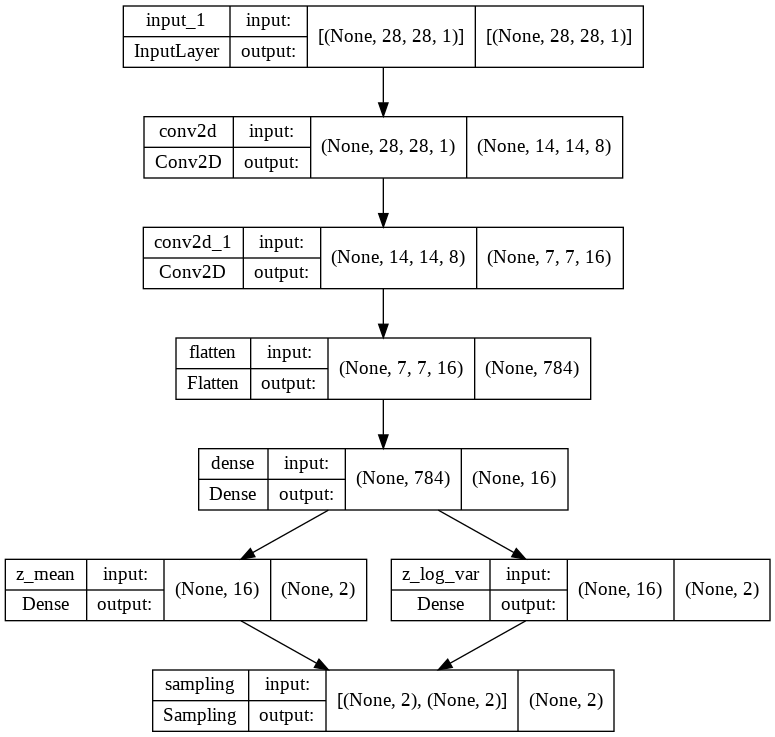

In [5]:
plot_model( encoder, os.path.join(tempdir, "vae_conv_encoder.png"), show_shapes=True)

## Build the decoder

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 32, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 32))(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(8, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 1568)              4704      
                                                                 
 reshape (Reshape)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 16)       4624      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 8)        1160      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        73  

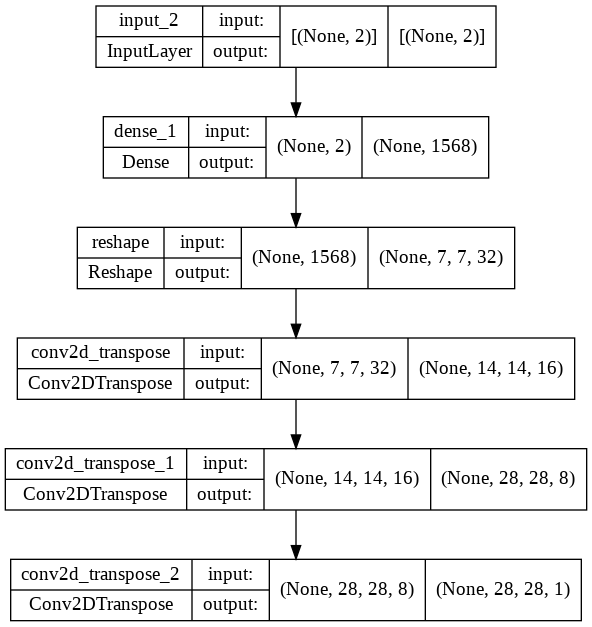

In [7]:
plot_model( decoder, os.path.join(tempdir, "vae_conv_decoder.png"), show_shapes=True)

## Define the VAE as a `Model` with a custom `train_step`

In [8]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Train the VAE

In [9]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 50s 87ms/step - loss: 290.3838 - reconstruction_loss: 218.8498 - kl_loss: 3.1986
Epoch 2/30
547/547 [==============================] - 38s 69ms/step - loss: 176.7334 - reconstruction_loss: 170.1230 - kl_loss: 4.4114
Epoch 3/30
547/547 [==============================] - 40s 73ms/step - loss: 170.0212 - reconstruction_loss: 164.7926 - kl_loss: 4.6208
Epoch 4/30
547/547 [==============================] - 38s 69ms/step - loss: 167.0016 - reconstruction_loss: 161.9121 - kl_loss: 4.7832
Epoch 5/30
547/547 [==============================] - 38s 69ms/step - loss: 165.4225 - reconstruction_loss: 160.0135 - kl_loss: 4.9251
Epoch 6/30
547/547 [==============================] - 38s 70ms/step - loss: 163.5250 - reconstruction_loss: 158.5147 - kl_loss: 5.0365
Epoch 7/30
547/547 [==============================] - 38s 69ms/step - loss: 162.5331 - reconstruction_loss: 157.3816 - kl_los

## Display a grid of sampled digits

kjp:

Notes
- The argument to `vae.decoder` is `z_sample`, which is a draw from a distribution with mean `z_mean` and log variance `z_log_var`
  - `z_mean`, `z_log_var` and `z_sample` all are of dimension `latent_dim = 2`
- The loop below creates `z_sample = [ [xi, yi] ]`
  - `xi` and `yi` are the components of `z_sample` (`[xi, yi]` is of length 2)
    - the `z_sample` thus createdis equivalent to having drawn a sample from distribution with 
      - mean `[xi, yi]` and ZERO variance
      - in particular: `yi` is NOT a variance, just the second component of the mean

In [10]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    fig = plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    
    plt.show()

    return fig


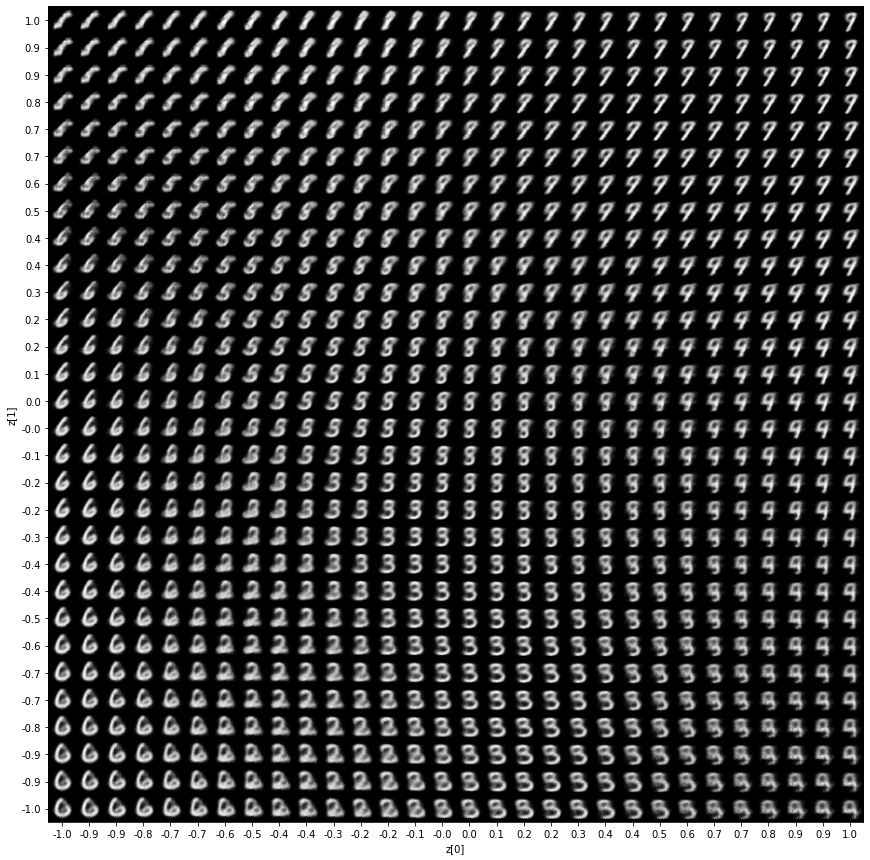

In [11]:
fig = plot_latent_space(vae)

In [12]:
fig.savefig( os.path.join(tempdir, "vae_outputgrid.png"))


## Display how the latent space clusters different digit classes

In [13]:

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    fig = plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")

    fig.show()
    
    return fig
   


In [14]:


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255



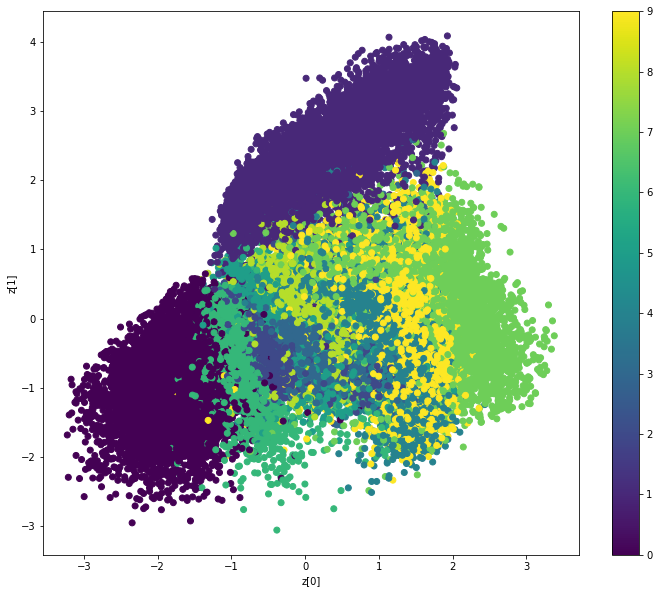

In [15]:
fig = plot_label_clusters(vae, x_train, y_train)

In [16]:
fig.savefig( os.path.join(tempdir, "vae_latents.png"))
 

# Conditional VAE

## Define the Conditional VAE as a `Model` with a custom `train_step`

The Conditional VAE differs only slightly for the VAE
- the `encoder` takes 2 input arguments
  - a list of length 2: `[encoder_inputs, encoder_labels]`
  - rather than a singleton, non-list: `encoder_inputs`
- the `decoder` similarly takes as input a list of length 2 rather than a singleton, non-list
  - `[latent_inputs, decoder_labels]`
- the label arguments are One Hot Encoded vectors

The `encoder` just passes the label parameter to the output; it does not affect the latent representaion

The `decoder`
- concatenates the OHE of the label to the latent created by the `encoder`
- and just treats it like a longer latent
  - same processing as the plain VAE

In [19]:
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

mnist_labels = np.concatenate([y_train, y_test], axis=0)
mnist_labels = to_categorical(mnist_labels)

num_y = mnist_labels.shape[-1]

In [20]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
encoder_labels = keras.Input(shape=(num_y))

x = layers.Conv2D(8, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)

# Concatenate the label
x = tf.concat([x, encoder_labels], axis=1)

x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
c_encoder = keras.Model([encoder_inputs, encoder_labels], [z_mean, z_log_var, z], name="encoder")
c_encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 8)    80          ['input_3[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 16)     1168        ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['conv2d_3[0][0]']               
                                                                                            

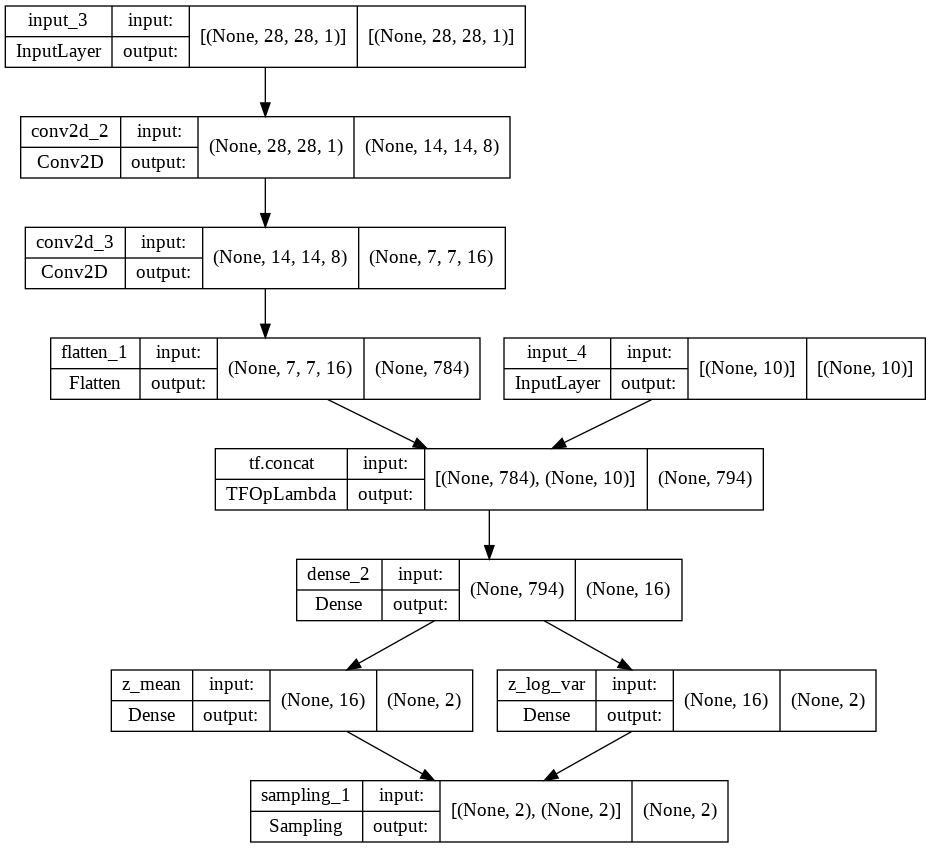

In [21]:
plot_model( c_encoder, os.path.join(tempdir, "cond_vae_conv_encoder.png"), show_shapes=True)

In [22]:
latent_inputs = keras.Input(shape=(latent_dim,))
decoder_labels = keras.Input(shape=(num_y))

# Concatenate the label
x = tf.concat([latent_inputs, decoder_labels], axis=1)

x = layers.Dense(7 * 7 * 32, activation="relu")(x)
x = layers.Reshape((7, 7, 32))(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(8, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
c_decoder = keras.Model([latent_inputs, decoder_labels], decoder_outputs, name="decoder")
c_decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 tf.concat_1 (TFOpLambda)       (None, 12)           0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 1568)         20384       ['tf.concat_1[0][0]']      

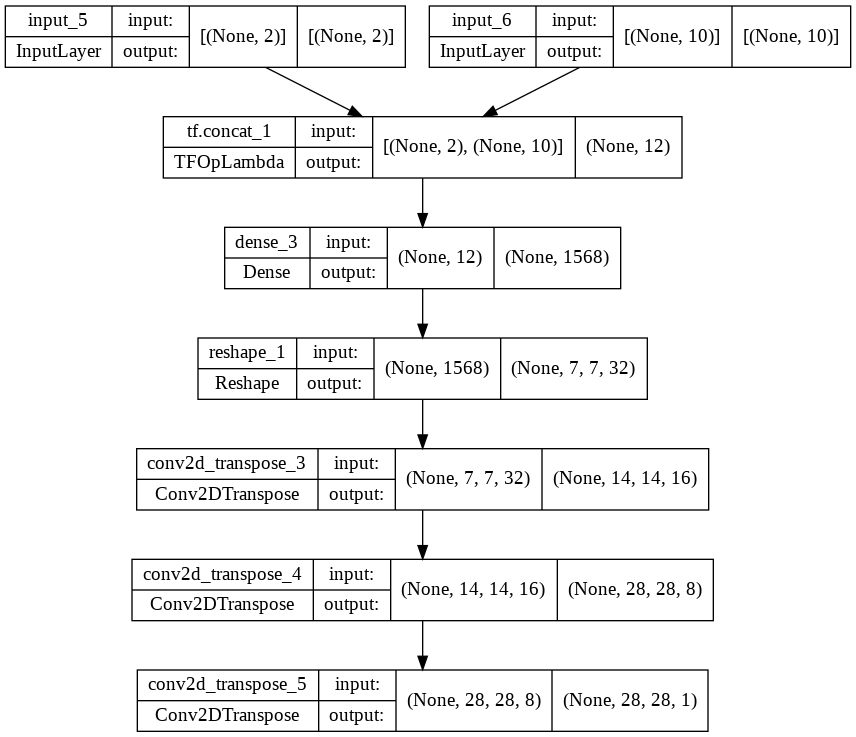

In [23]:
plot_model( c_decoder, os.path.join(tempdir, "cond_vae_conv_decoder.png"), show_shapes=True)

kjp:

Notes
- The second argument to `train_step` is a tuple
- The elements of the tuple are the initial parameters passed to `fit`
  - the number of elements depends on the `fit` call
    - e.g., `cvae.fit( arg0, arg1, epochs=.. )` will pass a tuple with 2 elements


In [24]:
from tensorflow.python.eager.execute import args_to_matching_eager
import pdb

class CVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = c_encoder
        self.decoder = c_decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, args):

        # dict_arg = arg_tuple[0]
        # print("Dict arg: ", type(dict_arg))
        # pdb.set_trace()

        # data, labels = dict_arg["data"], dict_arg["labels"]
        data, labels = args

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([data, labels])
            reconstruction = self.decoder([z, labels])
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [25]:
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer=keras.optimizers.Adam())
cvae.fit(  mnist_digits, mnist_labels, epochs=30, batch_size=128)


Epoch 1/30
547/547 [==============================] - 46s 81ms/step - loss: 277.6284 - reconstruction_loss: 194.4749 - kl_loss: 2.1069
Epoch 2/30
547/547 [==============================] - 40s 73ms/step - loss: 142.3354 - reconstruction_loss: 136.3802 - kl_loss: 4.2150
Epoch 3/30
547/547 [==============================] - 39s 71ms/step - loss: 138.0802 - reconstruction_loss: 133.2052 - kl_loss: 4.4035
Epoch 4/30
547/547 [==============================] - 39s 71ms/step - loss: 136.3367 - reconstruction_loss: 131.7898 - kl_loss: 4.4705
Epoch 5/30
547/547 [==============================] - 39s 72ms/step - loss: 135.3963 - reconstruction_loss: 130.9663 - kl_loss: 4.4956
Epoch 6/30
547/547 [==============================] - 39s 71ms/step - loss: 134.9519 - reconstruction_loss: 130.3465 - kl_loss: 4.5214
Epoch 7/30
547/547 [==============================] - 39s 71ms/step - loss: 134.7895 - reconstruction_loss: 129.9592 - kl_loss: 4.5222
Epoch 8/30
547/547 [==============================] - 4

## Display a grid of sampled digits with a chosen label

kjp:

Notes
- The argument to `vae.decoder` is `z_sample`, which is a draw from a distribution with mean `z_mean` and log variance `z_log_var`
  - `z_mean`, `z_log_var` and `z_sample` all are of dimension `latent_dim = 2`
- The loop below creates `z_sample = [ [xi, yi] ]`
  - `xi` and `yi` are the components of `z_sample` (`[xi, yi]` is of length 2)
    - the `z_sample` thus createdis equivalent to having drawn a sample from distribution with 
      - mean `[xi, yi]` and ZERO variance
      - in particular: `yi` is NOT a variance, just the second component of the mean

In [26]:
import matplotlib.pyplot as plt


def plot_latent_space_c(vae, label=0, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    label_np = to_categorical(label, num_classes=10)
    label_np = np.expand_dims(label_np, 0)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder([z_sample, label_np])

            # KJP: had to add: .numpy() here b/c we invoke as vae.decoder() instead of original vae.decoder.predict; why does original .predict work ?
            digit = x_decoded[0].numpy().reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    fig = plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")

    plt.show()

    return fig
   



We can now control which digit gets generated
- could not do that in the plain VAE

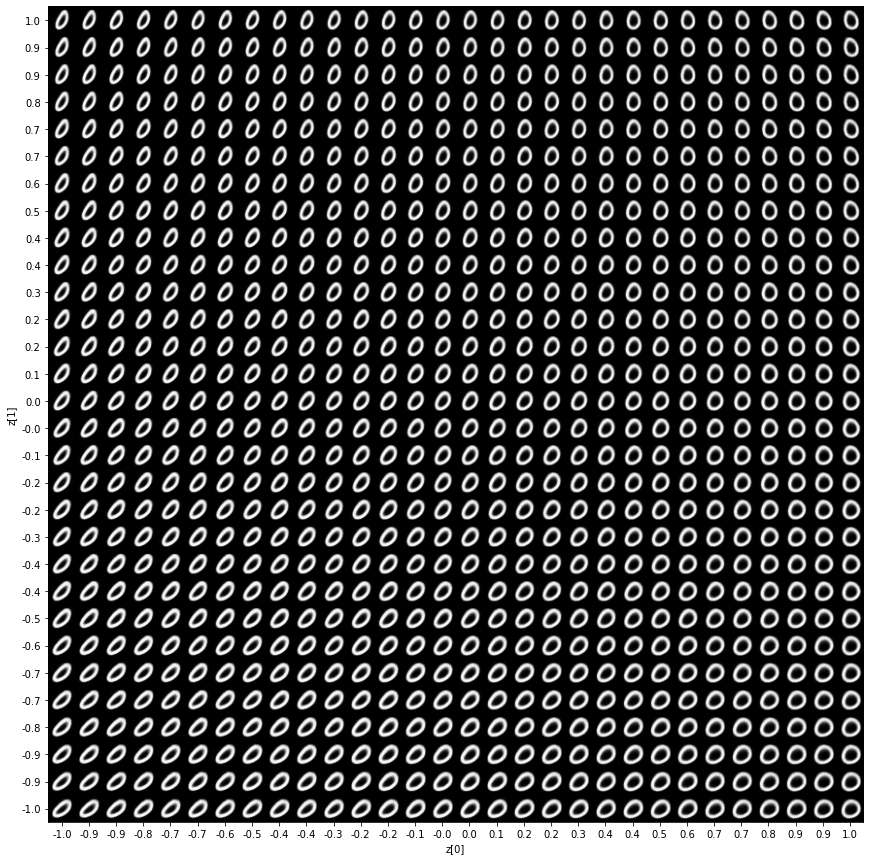

In [27]:
fig = plot_latent_space_c(cvae, label=0)

In [28]:
fig.savefig( os.path.join(tempdir, "cond_vae_outputgrid.png"))



The two axes are variations of the two components of `z_mean`, the mean of the latent representation
- one component: controls tilt of digit?
- other componenet: controls width of digit ?